<a href="https://colab.research.google.com/github/CHENGIHSIEN/Image-classification/blob/main/Week07_Image_Classification_Competition_My_VIT_model_with_MixUp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification Competition-My VIT model with MixUp

## Push to github

In [15]:
!git config --global user.name ''
!git config --global user.email ''
!git config --global user.password ''

In [16]:
token = ''
username = ''
repo = ''

In [ ]:
# clone
# !git clone https://{token}@github.com/{username}/{repo}
# Go into our repo folder
# %cd
# ls
# Move the file　we want to the cloned folder
# !mv 'path'
# !git status
# !git add .
# Stage and commit with a message
# !git commit -am "Add the file to the Image-classification-project repo"
# Check the url of the remote,"v" stand for verbose
# !git remote -v
# Push to the remote
# !git push origin master

In [ ]:
!git add .

fatal: not a git repository (or any of the parent directories): .git


## Introduction
This mission is to implement a deep neural network model capable of classifying three different kinds of noodles: spaghetti, ramen, and udon, with higher accuracy.

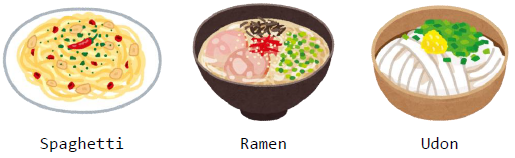

## About Competition




### Kaggle


*   The competition is held on the Kaggle platform.
*   Please join the competition from the invitation link on our Teams channel.



## Data Preparation

### GPU

Please make sure your runtime type is set to GPU (cuda).

In [ ]:
import torch

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)
# torch.cuda.set_per_process_memory_fraction(0.7)

cuda


### General Packages

Let's import some general Python packages.

In [ ]:
# pip install transformers

In [ ]:
# pip install tqdm and gdown and torchinfo and timm

In [ ]:
# conda install -n base -c conda-forge widgetsnbextension ipywidgets

In [ ]:
# pip install pandas and gdown

In [ ]:
# pip install matplotlib and seaborn and tqdm

In [ ]:
# conda list

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
import seaborn as sns
from tqdm.auto import tqdm
import os
import gdown
import torch.nn as nn
import torchvision.models as models

### Download Data

Unlike the CIFAR10 dataset, the data we will be using here consists of regular JPEG files. Therefore, we need to prepare the dataset for PyTorch to process.

The noodle image data can be downloaded using the code below. Once the download is complete, you will find 'noodles_dataset.zip' in the Files tab on the left side.

In [ ]:
gdown.download('https://drive.google.com/uc?id=1-JwyQvDp1k9FEwf6_Z1553rh0hCtOewF', 'noodles_dataset_3k.zip', quiet = False)

Downloading...
From: https://drive.google.com/uc?id=1-JwyQvDp1k9FEwf6_Z1553rh0hCtOewF
To: /content/noodles_dataset_3k.zip
100%|██████████| 142M/142M [00:01<00:00, 86.9MB/s]


'noodles_dataset_3k.zip'

In [ ]:
import os
current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

Current Working Directory: /content


In [ ]:
import zipfile

# Specify the path to the ZIP file and the destination directory
zip_file_path = 'noodles_dataset_3k.zip'
destination_directory = 'C:/Users/user/Desktop/Image_recognition_competition'

# Open the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents to the destination directory
    zip_ref.extractall(destination_directory)

In [ ]:
# This is for colab not for jupyter notebook
! unzip noodles_dataset_3k.zip > /dev/null 2>&1

Then unzip `noodles_dataset.zip` then you will find `noodles_dataset` directory in the Files tab.

In the `noodles_dataset` directory, you will find two main directories named `test` and `test`. Within the `train` directory, there are subdirectories labeled `0_spaghetti`, `1_ramen`, and `2_udon`, each containing respective images of spaghetti, ramen, and udon. Inside the `test` directory, there is a subdirectory named `unknown`, which contains spaghetti, ramen, and udon images mixed together in a random order.

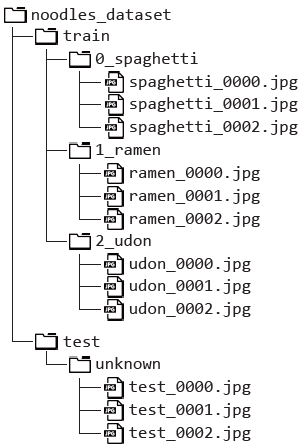

Let's check how many image data we have.

In [ ]:
for subdir in ["train", "test"]:
    print(subdir)
    subsubdirs = sorted(os.listdir(os.path.join("noodles_dataset_3k", subdir)))
    for subsubdir in subsubdirs:
        filenames = os.listdir(os.path.join("noodles_dataset_3k", subdir, subsubdir))
        print("---", subsubdir, ":", len(filenames))

train
--- 0_spaghetti : 1000
--- 1_ramen : 1000
--- 2_udon : 1000
test
--- unknown : 1000


### Create Dataset
To create PyTorch datasets with this tree-structured directory format, we can use `torchvision.datasets.ImageFolder` class.

In [ ]:
from torchvision.datasets import ImageFolder

train_dataset = ImageFolder(root="noodles_dataset_3k/train")
test_dataset = ImageFolder(root="noodles_dataset_3k/test")

print("train_dataset:", len(train_dataset))
print("test_dataset:", len(test_dataset))

train_dataset: 3000
test_dataset: 1000


Let's take a look at some spaghetti data within the `train_dataset`.

In [ ]:
import torch
image, label=train_dataset[0]
# Get the size of the image
image_size = image.size

# Display the size
print("Image Size:", image_size)

Image Size: (300, 168)


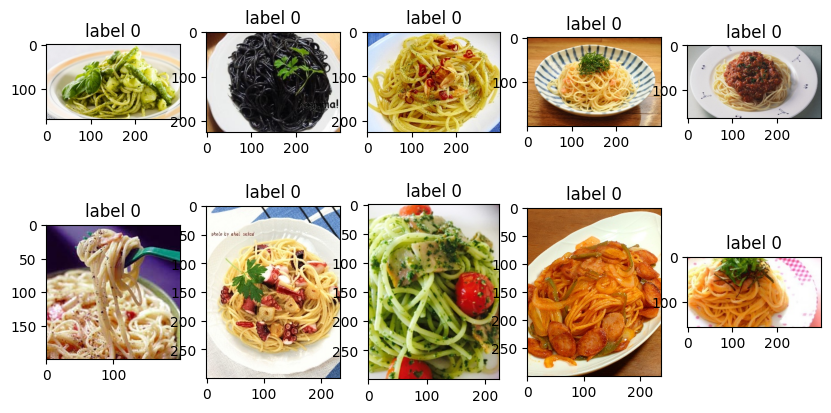

In [ ]:
plt.figure(figsize=(10, 5))

for i in range(10):
    image, label = train_dataset[i]
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.title(f"label {label}")

Let's take a look at some ramen data within the `train_dataset`.

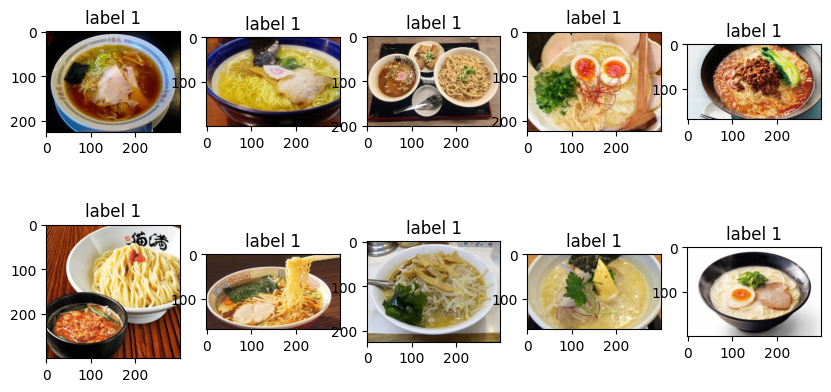

In [ ]:
plt.figure(figsize=(10, 5))

for i in range(10):
    image, label = train_dataset[i+1000]
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.title(f"label {label}")

Let's take a look at some udon data within the `train_dataset`.

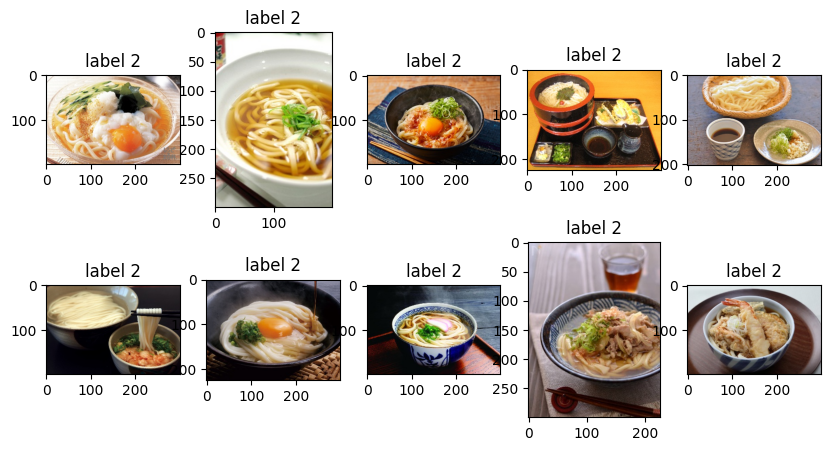

In [ ]:
plt.figure(figsize=(10, 5))

for i in range(10):
    image, label = train_dataset[i+2000]
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.title(f"label {label}")

As you can see above, spaghetti, ramen, and udon images are labeled as "0", "1", and "2", respectively.

This labeling is automatically assigned based on the directory names within the `train` directory specified in `ImageFolder`. You can check the assigned label numbers as demonstrated below.

In [ ]:
train_dataset.class_to_idx

{'0_spaghetti': 0, '1_ramen': 1, '2_udon': 2}

Here, we are creating a dictionary to map the class names.

In [ ]:
classnames = {0:"spaghetti", 1:"ramen", 2:"udon"}
classnames

{0: 'spaghetti', 1: 'ramen', 2: 'udon'}

Let's take a look at some data within the `test_dataset`.

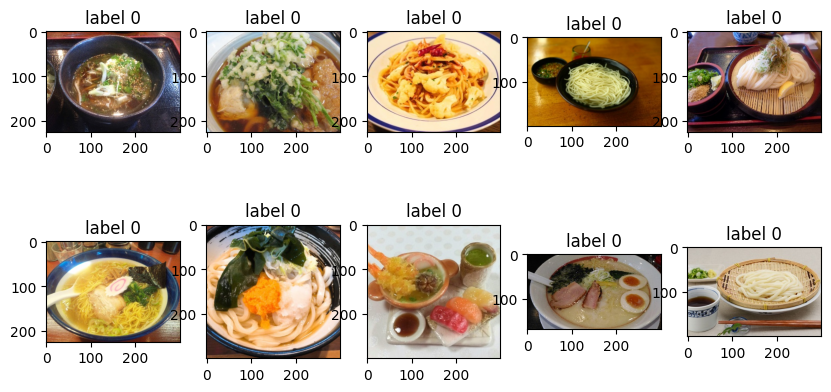

In [ ]:
plt.figure(figsize=(10, 5))

for i in range(10):
    image, label = test_dataset[i]
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.title(f"label {label}")

Since there is only one subdirectory named `unknown` in the `test` directory, all the images within it are labeled as `0`.

In [ ]:
test_dataset.class_to_idx

{'unknown': 0}

To feed image data into a PyTorch model, it's essential that all image data shares the same dimensions. In this step, we resize all the image data to 96x96 pixels and convert it to the `torch.tensor` format. Additionally, you have the option to apply further preprocessing techniques such as data standardization and data augmentation at this stage.

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


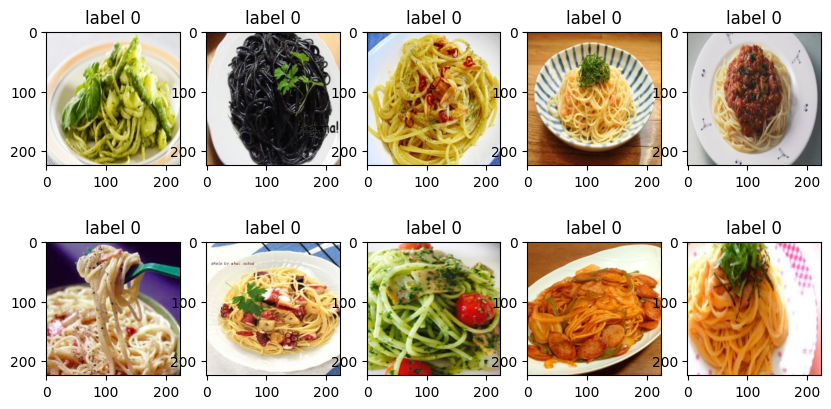

In [ ]:
from torchvision.transforms import v2

image_size=224

train_dataset = ImageFolder(root="C:/Users/user/Desktop/Image_recognition_competition/noodles_dataset_3k/train",
                transform=v2.Compose([
                #v2.RandomHorizontalFlip(),
                #v2.RandomVerticalFlip(),
                #v2.RandomCrop(size=(300, 168)),
                #v2.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
                #v2.RandomPerspective(distortion_scale=0.6, p=1.0),
                #v2.RandomRotation(degrees=(0, 180)),
                #v2.RandomGrayscale(p=0.4),
                #v2.Pad(padding=4, fill=0, padding_mode='constant'),
                #v2.Pad(padding=4, fill=0, padding_mode='constant'),
                v2.Resize((image_size, image_size)),
                v2.ToTensor(),
                                ])
                       )

test_dataset = ImageFolder(root="C:/Users/user/Desktop/Image_recognition_competition/noodles_dataset_3k/test",
                           transform=v2.Compose([
                                v2.Resize((image_size, image_size)),
                                v2.ToTensor()
                                ])
                      )

plt.figure(figsize=(10,5))

for i in range(10):
    image, label = train_dataset[i]
    image = image.permute(1,2,0)
    pil_image = ToPILImage(image)
    plt.subplot(2, 5, i+1)
    plt.imshow(image)

    plt.title(f"label {label}")
#plt.show()


### Data Splitting

Since all of the test dataset is labeled as `0`, which means they are not labeled correctly, we cannot use them to evaluate the trained model.

Therefore, we need to create another dataset for evaluation, commonly known as the validation dataset. Typically, the validation dataset is created by splitting the original training dataset. In this case, we are splitting the train_dataset into two datasets: `valid_dataset` and a new `train_dataset`.

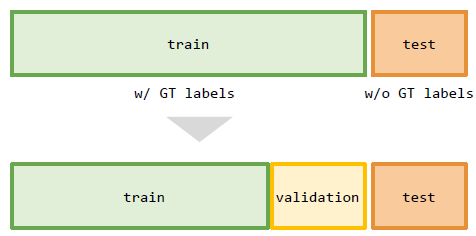

In [ ]:
from torch.utils.data import random_split

n_samples = len(train_dataset)
train_size = int(n_samples * 0.8)    # 80% will be training data
valid_size = n_samples - train_size

train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

print("train data", len(train_dataset))
print("validation data", len(valid_dataset))

train data 2400
validation data 600


### DataLoader

Then we create the dataloaders for the training, validation and test dataset.

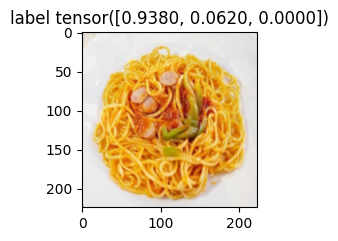

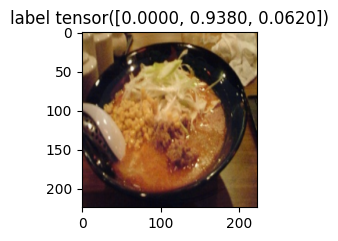

In [ ]:
from torch.utils.data import default_collate
from torch.utils.data import DataLoader

mixup=v2.MixUp(alpha=0.2, num_classes=3, labels_getter="default") # 0.4 is the best. If it exceed 1 some error will appear


def collate_fn(batch):
    return mixup(*default_collate(batch))


batch=256
num_workers=0

train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True, num_workers=num_workers,pin_memory=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch, shuffle=False, num_workers=num_workers,pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=False, num_workers=num_workers,pin_memory=True)

for i, (images, labels) in enumerate(train_loader):
    # Limit the loop to the first 10 batches
    if i >= 1:
        break
    for j in range(2):
      image = images[j].permute(1, 2, 0).cpu().numpy()
      # Extract the label information based on your data format
      label = labels[j]
      plt.figure(figsize=(5,5))

      plt.subplot(2, 1, j+1)
      plt.imshow(image)
      plt.title(f"label {label}")


## Model Building

## Training

### Training Loop







In [ ]:
# import torch.optim as optim
# import torchvision.models as models
# from transformers import ViTImageProcessor, ViTForImageClassification

# # Define early stopping parameters
# early_stopping_patience = 3
# best_valid_accuracy = 0.0
# no_improvement_count = 0

# epochs = 32   # Some material say start from classes*2

# model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')







In [ ]:
# # Modify the last classification layer for 3 classes
# num_classes = 3
# model.classifier = nn.Linear(model.vit.config.hidden_size, num_classes)

# # Print the modified model
# print(model)

In [ ]:
import torch.optim as optim
import torchvision.models as models
from transformers import ViTImageProcessor, ViTForImageClassification
import requests

# Define early stopping parameters
early_stopping_patience = 32
best_valid_accuracy = 0.0
no_improvement_count = 0

epochs = 32   # Some material say start from classes*2

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
# Modify the last classification layer for 3 classes
num_classes = 3
model.classifier = nn.Linear(model.vit.config.hidden_size, num_classes)


for param in model.parameters():                 # freeze all parameters
    param.requires_grad = False
model.classifier.weight.requires_grad = True
model.classifier.bias.requires_grad = True

model = model.to(device)                                # load model on GPU
loss_func = nn.CrossEntropyLoss()                      # set loss function
optimizer = optim.Adam(model.parameters(), lr=1E-3)    # set optimizer

# create empty lists for saving metrics during training
train_loss_list = []
train_accuracy_list = []
valid_loss_list = []
valid_accuracy_list = []
current_epochs=0

for epoch in range(epochs):

    # Update current epochs
    current_epochs+=1

    print(f"Epoch {epoch+1}/{epochs}")

    # initialize metrics value
    train_correct_count = 0
    train_accuracy = 0
    train_loss = 0
    valid_correct_count = 0
    valid_accuracy = 0
    valid_loss = 0

    #--- Training Phase ---#
    model.train()    # set model to training mode

    pbar = tqdm(train_loader)
    pbar.set_description("Train")

    for x_batch, y_batch in pbar:      # take mini batch data from train_loader

        x_batch = x_batch.to(device)     # load x_batch data on GPU
        y_batch = y_batch.to(device)     # load y_batch data on GPU


        optimizer.zero_grad()                  # reset gradients to 0
        p_batch = model(x_batch)               # do prediction
        # Here, p_batch is an ImageClassifierOutput object,
        # which requires you to extract the logits using p_batch.logits before applying the cross-entropy loss

        p_batch = p_batch.logits  # Extract logits from ImageClassifierOutput
        loss = loss_func(p_batch, y_batch)  # measure loss

        loss.backward()                        # calculate gradients
        optimizer.step()                       # update model parameters

        train_loss += loss.item()                                # accumulate loss value
        p_batch_label = torch.argmax(p_batch, dim=1)             # convert p_batch vector to p_batch_label
        y_batch = torch.argmax(y_batch, dim=1)
        train_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions

        pbar.set_postfix({"accuracy":f"{(p_batch_label == y_batch).sum()/len(x_batch):.4f}", "loss": f"{loss.item():.4f}"})
    #----------------------#

    #--- Evaluation Phase ---#
    with torch.no_grad():   # disable autograd for saving memory usage
        model.eval()        # set model to evaluation mode

        pbar = tqdm(valid_loader)
        pbar.set_description("Valid")

        for x_batch, y_batch in pbar:   # take mini batch data from test_loader

            x_batch = x_batch.to(device)     # load x_batch data on GPU
            y_batch = y_batch.to(device)     # load y_batch data on GPU

            p_batch = model(x_batch)              # do prediction
            p_batch = p_batch.logits  # Extract logits from ImageClassifierOutput
            loss = loss_func(p_batch, y_batch)  # measure loss

            valid_loss += loss.item()                                # accumulate loss value
            p_batch_label = torch.argmax(p_batch, dim=1)        # convert p_batch vector to p_batch_label
            valid_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions

            pbar.set_postfix({"accuracy":f"{(p_batch_label == y_batch).sum()/len(x_batch):.4f}", "loss": f"{loss.item():.4f}"})



    #------------------------#

    train_accuracy = train_correct_count.item()/len(train_dataset)   # determine accuracy for training data
    valid_accuracy = valid_correct_count.item()/len(valid_dataset)   # determin accuracy for test data
    train_loss = train_loss/len(train_loader)       # determin loss for training data
    valid_loss = valid_loss/len(valid_loader)       # determin loss for validation data

    # Update the best accuracy and no_improvement_count
    if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy
        no_improvement_count = 0
        # Save the best model (optional)
        torch.save(model.state_dict(), "best_model.pth")
    else:
        no_improvement_count += 1

    # show and store metrics
    print(f"Train: Accuracy={train_accuracy:.3f} Loss={train_loss:.3f}, Valid: Accuracy={valid_accuracy:.3f} Loss={valid_loss:.3f}")
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    valid_accuracy_list.append(valid_accuracy)
    valid_loss_list.append(valid_loss)

    print("---------------------")

    # End training if no_improvement_count exceed early_stopping_patience
    if no_improvement_count >= early_stopping_patience:
        print(f"Early stopping! Validation accuracy has not improved for {early_stopping_patience} epochs.")
        print(f"Current epochs={current_epochs}")
        break  # End training

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1/32


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train: Accuracy=0.670 Loss=0.759, Valid: Accuracy=0.852 Loss=0.452
---------------------
Epoch 2/32


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train: Accuracy=0.843 Loss=0.581, Valid: Accuracy=0.883 Loss=0.332
---------------------
Epoch 3/32


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train: Accuracy=0.832 Loss=0.508, Valid: Accuracy=0.890 Loss=0.284
---------------------
Epoch 4/32


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train: Accuracy=0.881 Loss=0.405, Valid: Accuracy=0.908 Loss=0.258
---------------------
Epoch 5/32


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train: Accuracy=0.909 Loss=0.394, Valid: Accuracy=0.920 Loss=0.242
---------------------
Epoch 6/32


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train: Accuracy=0.890 Loss=0.483, Valid: Accuracy=0.923 Loss=0.241
---------------------
Epoch 7/32


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train: Accuracy=0.905 Loss=0.431, Valid: Accuracy=0.932 Loss=0.234
---------------------
Epoch 8/32


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train: Accuracy=0.873 Loss=0.446, Valid: Accuracy=0.938 Loss=0.229
---------------------
Epoch 9/32


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train: Accuracy=0.883 Loss=0.398, Valid: Accuracy=0.938 Loss=0.215
---------------------
Epoch 10/32


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train: Accuracy=0.925 Loss=0.437, Valid: Accuracy=0.940 Loss=0.214
---------------------
Epoch 11/32


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train: Accuracy=0.938 Loss=0.291, Valid: Accuracy=0.943 Loss=0.204
---------------------
Epoch 12/32


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train: Accuracy=0.937 Loss=0.422, Valid: Accuracy=0.952 Loss=0.198
---------------------
Epoch 13/32


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train: Accuracy=0.895 Loss=0.522, Valid: Accuracy=0.950 Loss=0.211
---------------------
Epoch 14/32


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train: Accuracy=0.907 Loss=0.421, Valid: Accuracy=0.950 Loss=0.215
---------------------
Epoch 15/32


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train: Accuracy=0.944 Loss=0.435, Valid: Accuracy=0.952 Loss=0.200
---------------------
Epoch 16/32


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train: Accuracy=0.915 Loss=0.510, Valid: Accuracy=0.950 Loss=0.208
---------------------
Epoch 17/32


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train: Accuracy=0.948 Loss=0.376, Valid: Accuracy=0.953 Loss=0.205
---------------------
Epoch 18/32


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train: Accuracy=0.949 Loss=0.340, Valid: Accuracy=0.955 Loss=0.187
---------------------
Epoch 19/32


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train: Accuracy=0.915 Loss=0.496, Valid: Accuracy=0.958 Loss=0.195
---------------------
Epoch 20/32


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train: Accuracy=0.868 Loss=0.532, Valid: Accuracy=0.955 Loss=0.199
---------------------
Epoch 21/32


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train: Accuracy=0.954 Loss=0.292, Valid: Accuracy=0.957 Loss=0.190
---------------------
Epoch 22/32


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train: Accuracy=0.916 Loss=0.393, Valid: Accuracy=0.953 Loss=0.185
---------------------
Epoch 23/32


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train: Accuracy=0.958 Loss=0.300, Valid: Accuracy=0.957 Loss=0.175
---------------------
Epoch 24/32


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train: Accuracy=0.930 Loss=0.399, Valid: Accuracy=0.958 Loss=0.174
---------------------
Epoch 25/32


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train: Accuracy=0.915 Loss=0.422, Valid: Accuracy=0.958 Loss=0.178
---------------------
Epoch 26/32


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train: Accuracy=0.955 Loss=0.314, Valid: Accuracy=0.947 Loss=0.184
---------------------
Epoch 27/32


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train: Accuracy=0.962 Loss=0.236, Valid: Accuracy=0.955 Loss=0.167
---------------------
Epoch 28/32


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train: Accuracy=0.935 Loss=0.313, Valid: Accuracy=0.955 Loss=0.168
---------------------
Epoch 29/32


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train: Accuracy=0.967 Loss=0.300, Valid: Accuracy=0.960 Loss=0.162
---------------------
Epoch 30/32


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train: Accuracy=0.915 Loss=0.397, Valid: Accuracy=0.957 Loss=0.167
---------------------
Epoch 31/32


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train: Accuracy=0.970 Loss=0.219, Valid: Accuracy=0.960 Loss=0.159
---------------------
Epoch 32/32


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train: Accuracy=0.961 Loss=0.269, Valid: Accuracy=0.953 Loss=0.158
---------------------


### torchinfo
Let's see how the data shape changes in the model.

In [ ]:
!pip install torchinfo
from torchinfo import summary

for x_batch, _ in train_loader:
    break

input_shape = x_batch.shape
print(input_shape)

summary(model, input_shape)

torch.Size([256, 3, 224, 224])


Layer (type:depth-idx)                                  Output Shape              Param #
ViTForImageClassification                               [256, 3]                  --
├─ViTModel: 1-1                                         [256, 197, 768]           --
│    └─ViTEmbeddings: 2-1                               [256, 197, 768]           152,064
│    │    └─ViTPatchEmbeddings: 3-1                     [256, 196, 768]           (590,592)
│    │    └─Dropout: 3-2                                [256, 197, 768]           --
│    └─ViTEncoder: 2-2                                  [256, 197, 768]           --
│    │    └─ModuleList: 3-3                             --                        (85,054,464)
│    └─LayerNorm: 2-3                                   [256, 197, 768]           (1,536)
├─Linear: 1-2                                           [256, 3]                  2,307
Total params: 85,800,963
Trainable params: 2,307
Non-trainable params: 85,798,656
Total mult-adds (G): 51.41
Input 

### Learning Curves

Let's visualize the accuracy and the loss curves for training and validation data.

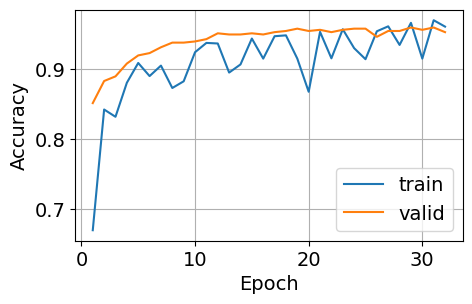

In [ ]:

plt.figure(figsize=(5, 3))
plt.rcParams["font.size"]=14
plt.plot(np.arange(1, current_epochs + 1), train_accuracy_list, label="train")
plt.plot(np.arange(1, current_epochs + 1), valid_accuracy_list, label="valid")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

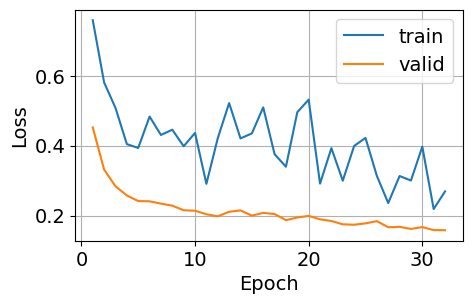

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(np.arange(1, current_epochs + 1), train_loss_list, label="train")
plt.plot(np.arange(1, current_epochs + 1), valid_loss_list, label="valid")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

## Evaluation

You may want to perform some evaluations with the validation data.

In [ ]:
test_accuracy = 0

y_test_all = np.array([])
p_label_all = np.array([])

with torch.no_grad():    # disable autograd
    model.eval()         # set model to evaluation mode

    for x_batch, y_batch in valid_loader:    # take mini batch data from train_loader
        x_batch = x_batch.to(device)        # transfer x_batch to gpu
        y_batch = y_batch.to(device)        # transfer y_batch to gpu
        p_batch = model(x_batch)              # do prediction
        p_batch = p_batch.logits  # Extract logits from ImageClassifierOutput
        loss = loss_func(p_batch, y_batch)  # measure loss

        p_batch_label = torch.argmax(p_batch, dim=1)       # convert p_batch vector to p_batch_label
        test_accuracy += (p_batch_label == y_batch).sum()  # count up number of correct predictions

        y_test_all = np.append(y_test_all, y_batch.to("cpu").numpy())          # append y_batch in y_test_all
        p_label_all = np.append(p_label_all, p_batch_label.to("cpu").numpy())  # append p_batch_label in p_label_all

test_accuracy = test_accuracy/len(valid_dataset)      # determine accuracy for test data
print(f"Test Accuracy = {test_accuracy:.3f}")


Test Accuracy = 0.953


In [ ]:
print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 1000
    Root location: C:/Users/user/Desktop/Image_recognition_competition/noodles_dataset_3k/test
    StandardTransform
Transform: Compose(
                 Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=warn)
                 ToTensor()
           )


## Submission

### Make Submission File

In [ ]:
# #####################
# ##  DO NOT CHANGE  ##
# #####################

# p_label_all = np.array([])

# with torch.no_grad():
#     model.eval()

#     for x_batch, y_batch in test_loader:
#         x_batch = x_batch.to(device)
#         y_batch = y_batch.to(device)

#         print(y_batch)
#         p_batch = model(x_batch)
#         p_batch_label = torch.argmax(p_batch, dim=1)
#         p_label_all = np.append(p_label_all, p_batch_label.to("cpu").numpy())

# p_label_all = p_label_all.astype("uint8")
# print(p_label_all)

# df_submit = pd.DataFrame()
# df_submit["ID"] = np.arange(1000)
# df_submit["Target"] = p_label_all

# df_submit.to_csv("your_submission.csv", index = False)

# df_submit

### Submition from Kaggle
You can now download `your_submission.csv` file from the 'Files' tab, and proceed to submit it on our competition page on Kaggle

## Conver to pdf

In [ ]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libfontenc1 libgs9 libgs9-common
  libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1
  libruby3.0 libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1
  libzzip-0-13 lmodern poppler-data preview-latex-style rake ruby
  ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils teckit tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-extra
  texlive-latex-recommended texlive-pictures tipa xfonts-encodings
  xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf libavalon-framework-java
  libcommons-logging-java-doc libexcalibu

In [ ]:
!jupyter nbconvert --to pdf /content/Week07_Image_Classification_Competition_My_VIT_model.ipynb

[NbConvertApp] WARNING | pattern '/content/Week07_Image_Classification_Competition_My_VIT_model.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalen